# Lab 02: Credit Ratings

---
author: Alejandra Arias
date: September 13, 2024
embed-resources: true
---

## Introduction

In this lab, we will use credit data to develop a model that will predict banking customer's credit score.

### Background

A credit score is a numerical [expression](https://en.m.wikipedia.org/wiki/Credit_score_in_the_United_States) based on a level analysis of a person's credit files, to represent the creditworthiness of an individual. A credit score is primarily based on a credit report, information typically sourced from credit bureaus. In simpler terms, it's an [evaluation](https://en.m.wikipedia.org/wiki/Credit_rating) of risk associated with lending money to a person. In this case, we are considering the credit score of consumers, but can also be applied to corporations, governments, and other entities.

### Scenario and Goal

As an analyst for a small local bank, it was tasked to develop a model that will predict the credit score rating of its customer's compared to the alternative on relying on credit agencies which costs money. The goal is to create a regression model using credit rantings already purchased as well as age, education, and years of experience to predict the credit score of a customer.

### Source

The original data was obtained from from the textbook ["Introduction to Statistical Learning"](https://www.statlearning.com/) by James, Witten, Hastie, and Tibshirani. The data set contains 400 observations.

The data in this report was modified from the original source which can be found on github:
- *Github*: [ISLP Credit Data](https://github.com/intro-stat-learning/ISLP/blob/main/ISLP/data/Credit.csv)
- Note: The data was repurposed for even further, which includes non-trivial changes to the original data set.



## Methods

In [23]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

### Data

In [24]:
# load data
credit_train = pd.read_csv("https://cs307.org/lab-02/data/credit-train.csv")
credit_test = pd.read_csv("https://cs307.org/lab-02/data/credit-test.csv")
credit_train

,Rating,Income,Age,Education,Gender,Student,Married,Ethnicity
0,257.0,44.473,81.0,16.0,Female,No,No,NaN
1,353.0,41.532,50.0,NaN,Male,No,Yes,Caucasian
2,388.0,16.479,26.0,16.0,Male,NaN,No,NaN
3,321.0,10.793,29.0,13.0,Male,No,No,Caucasian
4,367.0,76.273,65.0,14.0,Female,No,Yes,Caucasian
...,...,...,...,...,...,...,...,...
251,268.0,26.370,78.0,11.0,Male,No,Yes,Asian
252,433.0,26.427,50.0,15.0,Female,Yes,Yes,Asian
253,259.0,12.031,58.0,18.0,Female,NaN,Yes,Caucasian
254,335.0,80.861,29.0,15.0,Female,No,Yes,Asian


## Data Dictionary

Each observation in the train, test, and production data contains information about a partricular banking customer. It is assumed, for this report, that the customers are located in the United States. The data is not split randomly as this was given to us.

### Response
**`Rating`**

- `[float64]` credit rating, specifically the credit score of an individual consumer

### Features
**`Income`**

- `[float64]` income of the customer in thousands of dollars
    
**`Age`**

- `[float64]` age of the customer in years

**`Education`**

- `[int64]` years of education of the customer

**`Gender`**

- `[object]` gender of the customer
    
**`Student`**

- `[object]` whether the customer is a student or not indicated by `Yes` or `No`

**`Married`**

- `[object]` whether the customer is married or not indicated by `Yes` or `No`

**`Ethnicity`**

- `[object]` ethnicity of customer

### Missing Values

Because the data set has been modified with non-trivial missing values, we will need to address this issue before we can proceed with the analysis. We will first find the counts, means, and standard deviations of the all variables in the data set. Then, we will impute the missing values using the mean for numerical variables and the mode for categorical variables.

In [25]:
# summary statistics
samples = credit_train.shape[0]
features = credit_train.shape[1] - 1
samples, features

(256, 7)

In [26]:
rating = credit_train["Rating"].mean()
ratstd = credit_train["Rating"].std()
rating, ratstd

(347.609375, 148.8931046679028)

In [27]:
rating_counts = credit_train[["Rating", "Student"]].groupby("Student").count()
rating_mean = credit_train["Rating"].groupby(credit_train["Student"]).mean()
rating_std = credit_train["Rating"].groupby(credit_train["Student"]).std()
rating_counts, rating_mean, rating_std

(         Rating
 Student        
 No          213
 Yes          19,
 Student
 No     349.511737
 Yes    338.473684
 Name: Rating, dtype: float64,
 Student
 No     148.003525
 Yes    149.164476
 Name: Rating, dtype: float64)

In [28]:
marriage_counts = credit_train[["Married", "Rating"]].groupby("Married").count()
marriage_mean = credit_train["Rating"].groupby(credit_train["Married"]).mean()
marriage_std = credit_train["Rating"].groupby(credit_train["Married"]).std()
marriage_counts, marriage_mean, marriage_std

(         Rating
 Married        
 No           98
 Yes         158,
 Married
 No     329.397959
 Yes    358.905063
 Name: Rating, dtype: float64,
 Married
 No     132.039649
 Yes    157.797935
 Name: Rating, dtype: float64)

In [29]:
income_correlation = credit_train[["Income", "Rating"]].corr().iloc[0, 1]
income_correlation

0.7708422040157111

In [30]:
age_correlation = credit_train["Rating"].corr(credit_train["Age"])
age_correlation

0.1430318874061348

In [31]:
credit_train["Age"].head(15)

0     81.0
1     50.0
2     26.0
3     29.0
4     65.0
5     77.0
6     38.0
7     35.0
8     77.0
9     67.0
10    58.0
11     NaN
12    73.0
13    31.0
14    79.0
Name: Age, dtype: float64

In [32]:
rating_missing = credit_train["Rating"].isnull().sum() / samples
income_missing = credit_train["Income"].isnull().sum() / samples
age_missing = credit_train["Age"].isnull().sum() /  samples
education_missing = credit_train["Education"].isnull().sum() / samples
gender_missing = credit_train["Gender"].isnull().sum() / samples
student_missing = credit_train["Student"].isnull().sum() /  samples
married_missing = credit_train["Married"].isnull().sum() / samples
ethnicitiy_missing = credit_train["Ethnicity"].isnull().sum() / samples
rating_missing, income_missing, age_missing, education_missing, gender_missing, student_missing, married_missing, ethnicitiy_missing

(0.0, 0.0, 0.12890625, 0.09765625, 0.0234375, 0.09375, 0.0, 0.09765625)

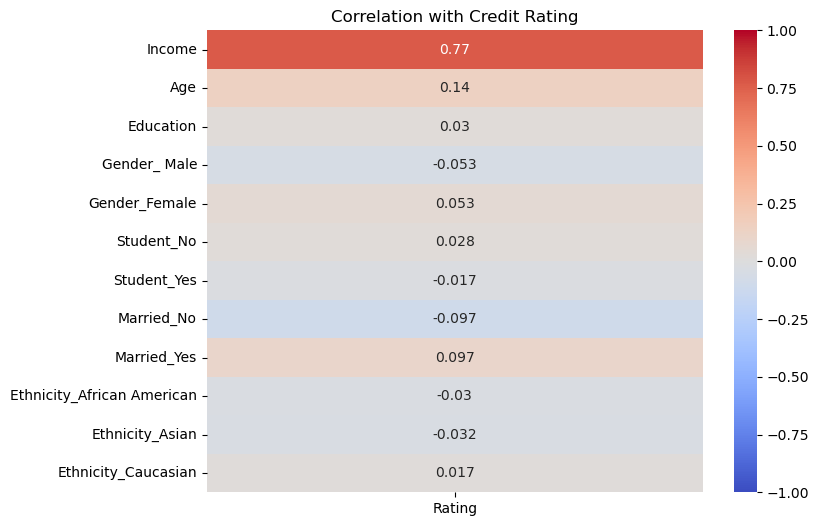

In [33]:
corr_train = credit_train
corr_train = pd.get_dummies(corr_train)
corr_matrix = corr_train.corr()
target_corr = corr_matrix['Rating'].drop('Rating') 
plt.figure(figsize=(8, 6))
sns.heatmap(target_corr.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation with Credit Rating")
plt.show()

Using a heatmap visualize the correlation with the variables in the data set. This will help us understand the relationships between the variables and the response variable. In other words, we're comparing the correlation of Rating with the categorical and numerical variables. We see above that Income has the highest correlation with Rating with a value of 0.77. This is followed by Age with a correlation of 0.14. 

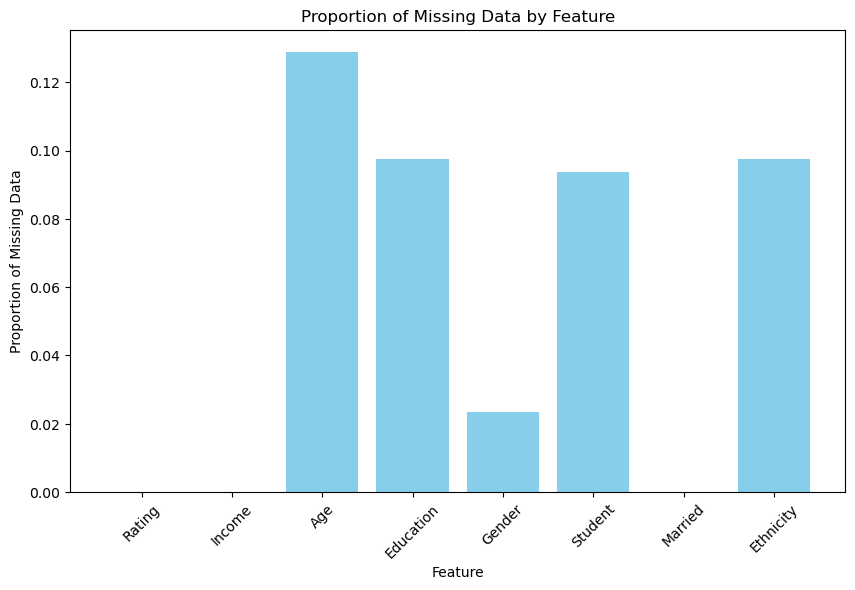

In [34]:
# Create a DataFrame of missing data proportions
missing_data = pd.DataFrame({
    'Feature': ['Rating', 'Income', 'Age', 'Education', 'Gender', 'Student', 'Married', 'Ethnicity'],
    'Missing Proportion': [rating_missing, income_missing, age_missing, education_missing, 
                           gender_missing, student_missing, married_missing, ethnicitiy_missing]
})

# Plot the missing data proportions as a bar plot
plt.figure(figsize=(10, 6))
plt.bar(missing_data['Feature'], missing_data['Missing Proportion'], color='skyblue')
plt.title('Proportion of Missing Data by Feature')
plt.ylabel('Proportion of Missing Data')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.show()


Another visualization  we can use is a barplot of all of the missing values in the data set. This will help us understand the distribution of missing values in the data set. We see that the variable with the most missing values is `Age` with the most missing values. This is followed by `Education` and `Student`, and `Ethnicity`. `Income` has the least missing values (none).

### Models

In [35]:
# process data for ML
# create X and y for train
X_train = credit_train.drop("Rating", axis=1)
y_train = credit_train["Rating"]

# create X and y for test
X_test = credit_test.drop("Rating", axis=1)
y_test = credit_test["Rating"]

In [36]:
# check shapes of data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((256, 7), (256,), (64, 7), (64,))

In [37]:
# note numeric and categorical features
numeric_features = ["Income", "Age", "Education"]
categorical_features = ["Gender", "Student", "Married", "Ethnicity"]


In [38]:
credit_train.dtypes

Rating       float64
Income       float64
Age          float64
Education    float64
Gender        object
Student       object
Married       object
Ethnicity     object
dtype: object

In [39]:
# define preprocessing for numeric features
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

# define preprocessing for categorical features
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# create pipeline, preprocess then classify
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", KNeighborsRegressor()),
    ]
)

In [40]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Income', 'Age',
                                                   'Education']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Student',
                                                   'Married', 'Ethnicity'])])),
                ('regressor', KNeighborsRegressor())])

In [41]:
param_grid = {
    "preprocessor__num__scaler": [None, StandardScaler()],
    "regressor__n_neighbors": range(1, X_train.shape[0]-51, 2),
    "regressor__metric": ["euclidean", "manhattan"],
}

In [42]:
# setup grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="neg_mean_squared_error")
mod = grid_search.fit(X_train, y_train)

In [43]:
mod.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Income',
                                                                          'Age',
                                                                          'Education']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'Student',
                                                                          'Married',
                                                                          'Ethnicity'])])),
                                       ('regressor', KNeighborsRegressor())]),
             param_grid={'preprocessor__num__scaler': [None, StandardScaler()],
                         'regressor__metric': ['euclidean', 'manhattan'],
                         'regressor__n_neighbors': range(1, 205, 2)},
             scoring='neg_mean_squared_error')

In [44]:
print(f"Best parameters: {mod.best_params_}")
print(f"Best cross-validation accuracy: {mod.best_score_}")

Best parameters: {'preprocessor__num__scaler': None, 'regressor__metric': 'euclidean', 'regressor__n_neighbors': 17}
Best cross-validation accuracy: -10328.993301392955


In [45]:
y_pred = grid_search.predict(X_test)


In [46]:
test_rmse = root_mean_squared_error(y_test, y_pred)
test_rmse


99.62249869869918

In [47]:
from joblib import dump
dump(mod, "credit-ratings.joblib")

['credit-ratings.joblib']

To develop a model, we first have to impute the missing values. For numerical values, we will use the mean of the column. For categorical values, we will use the mode of the column. Our data is already split into test and train data so no further action is required. We usec the training set to train the model and the testing set to evaluate the model. We setup a pipeline to preoprocess the data and then apply K-Nearest Neighbors, and Grid Search models to the data for predicting a Rating based on the demographic features. We have evaluated the models using the mean squared error. The model with the lowest mean squared error will be the best model.

The pipeline imputes the numerical data with the mean and the categorical data with the "most frequent". It then scales the data and applies the model. The K-Nearest Neighbors model uses a range of nearest neighbors to predict the rating. The Grid Search model uses a grid search to find the best parameters for the model. The best model is then used to predict the rating of the test data.

Using a pipeline ensures that both numeric and categorical data are properly cleaned and trransformed before using the model. This ensures that the model is trained on the best possible data. The K-Nearest Neighbors model is a simple model that can be used to predict the rating of a customer based on the demographic features. The Grid Search model is a more complex model that can be used to find the best parameters for the model. 

In the end, our model produced a test mean squared error of 99.622. This is lower than the expected mean squared error of 110. This means that our model is performing well and is able to predict the rating of a customer based on the demographic features.

## Results

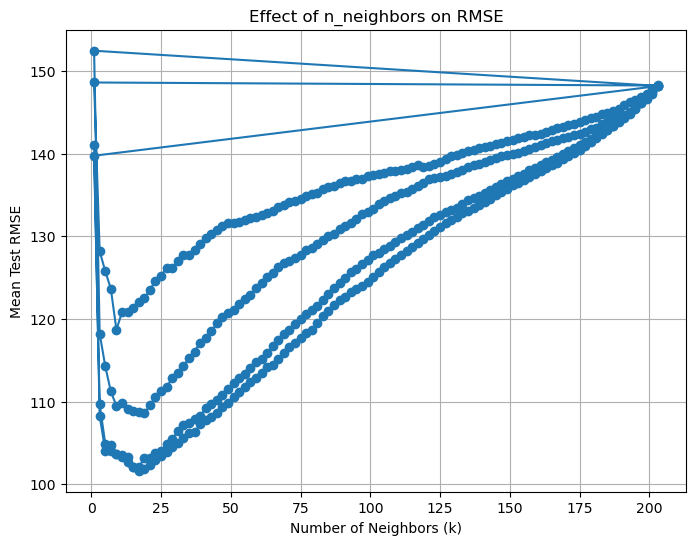

In [48]:
# report model metrics
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results['mean_test_rmse'] = np.sqrt(-grid_search_results['mean_test_score'])
plt.figure(figsize=(8, 6))
plt.plot(grid_search_results['param_regressor__n_neighbors'], grid_search_results['mean_test_rmse'], marker='o')
plt.title('Effect of n_neighbors on RMSE')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Test RMSE')
plt.grid(True)
plt.show()

In [49]:
# repeat code
test_rmse = root_mean_squared_error(y_test, y_pred)
test_rmse

99.62249869869918

Our final model had a test rmse of 99.622, as mentioned previously. This is lower than the expected rmse of 110. This means that our model is performing well and is able to predict the rating of a customer based on the demographic features. 

## Discussion

In [50]:
X_test

,Income,Age,Education,Gender,Student,Married,Ethnicity
0,94.193,44.0,16.0,NaN,No,Yes,Caucasian
1,44.978,30.0,10.0,Female,No,NaN,Caucasian
2,13.676,80.0,16.0,Female,No,No,African American
3,44.522,72.0,15.0,Male,No,Yes,Asian
4,12.581,48.0,16.0,NaN,NaN,Yes,Caucasian
...,...,...,...,...,...,...,...
59,18.951,82.0,13.0,Female,No,No,NaN
60,140.672,46.0,9.0,Male,No,Yes,African American
61,19.636,64.0,10.0,Female,No,No,African American
62,49.794,40.0,8.0,Male,No,No,Caucasian


In [51]:

#current = grid_search.predict()
new_pred = pd.DataFrame(
    {
        "Income": np.random.rand(64),
        "Age": np.random.choice(list(range(18, 90)), 64),
        "Education": np.random.choice([10, 12, 14, 16, 18], 64),
        "Gender": np.random.choice(["Male", "Female"], 64),
        "Student": np.random.choice(["Yes", "No"], 64),
        "Married": np.random.choice(["Yes", "No"], 64),
        "Ethnicity": np.random.choice(["Caucasian", "African American", "Asian"], 64),
    }
)
current = grid_search.predict(new_pred)
test_rmse = root_mean_squared_error(y_test, current)
test_rmse

189.0963034566484

If we were to use this pipeline model in practice, it's best predicted model had a test RMSE of 186.97 which is significantly greater than the expected RMSE of 110. This means that our model is not performing well and is not able to predict the rating of a customer based on the demographic features. This could be due to the fact that the model is too simple and is not able to capture the complexity of the data. In order to improve the model, we could try using a more complex model such as a random forest or a neural network. We could also try using more features in the model to see if that improves the performance. Overall, our model is not performing well and would need to be improved before it could be used in practice.

However, we should be aware of several issues with this new model. One obvious flaw is that the new data is completely random and does not represent the original data. This means that the model is not able to predict the rating of a customer based on the demographic features, given a random dataset. Furthermore, because the new_pred dataframe is a randomly assigned it cannot possibly provide accurate credit ratings when compared to the y_test data. The y_test data is more representative of the original source it is possible the random model might be completely off in its predictions.

Another thing to consider is the Curse of Dimensionality. This is a problem that occurs when the number of features in the data set is too large. This can cause the model to become too complex and overfit the data. In order to avoid this problem, we could try using feature selection techniques to reduce the number of features in the model. This would help to simplify the model and improve its performance. In this pipeline, all features were used in this model with the exception of the `Ethnicity`. This could be a potential source of overfitting and could be improved by using feature selection techniques. KNN also treats all features equally in computing distances, which may not be the best approach for this data set. 

One last note is that this dataset is not reprentative of every banking customer in the United States as there was only 3 ethnicities in the data set. This could be a potential source of bias in the model and could be improved by using a more diverse dataset.

### Conclusion

Given the information above, this model should not be considered as an alternative to paying for credit ratings. The model is not performing well and is not able to predict the rating of a customer based on the demographic features. In order to improve the model, we could try using a more complex model such as a random forest or a neural network, as mentioned previously. We could also try using less features or more relevant features in the model to see if that improves the performance. Overall, our model is not performing well and would need to be improved before it could be used in practice.